# MATH 4100: Temporal data analysis and applications to stock analysis
*Curtis Miller*

## Introduction

This is a lecture for [MATH 4100/CS 5160: Introduction to Data Science](http://datasciencecourse.net/), offered at the University of Utah, introducing time series data analysis applied to finance.

Advanced mathematics and statistics have been present in finance for some time. Prior to the 1980s, banking and finance were well-known for being "boring"; investment banking was distinct from commercial banking and the primary role of the industry was handling "simple" (at least in comparison to today) financial instruments, such as loans. Deregulation under the Regan administration, coupled with an influx of mathematical talent, transformed the industry from the "boring" business of banking to what it is today, and since then, finance has joined the other sciences as a motivation for mathematical research and advancement. For example one of the biggest recent achievements of mathematics was the derivation of the [Black-Scholes formula](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model), which facilitated the pricing of stock options (a contract giving the holder the right to purchase or sell a stock at a particular price to the issuer of the option). That said, [bad statistical models, including the Black-Scholes formula, hold part of the blame for the 2008 financial crisis](https://www.theguardian.com/science/2012/feb/12/black-scholes-equation-credit-crunch).

In recent years, computer science has joined advanced mathematics in revolutionizing finance and **trading**, the practice of buying and selling of financial assets for the purpose of making a profit. In recent years, trading has become dominated by computers; algorithms are responsible for making rapid split-second trading decisions faster than humans could make (so rapidly, [the speed at which light travels is a limitation when designing systems](http://www.nature.com/news/physics-in-finance-trading-at-the-speed-of-light-1.16872)). Additionally, [machine learning and data mining techniques are growing in popularity](http://www.ft.com/cms/s/0/9278d1b6-1e02-11e6-b286-cddde55ca122.html#axzz4G8daZxcl) in the financial sector, and likely will continue to do so. For example, **high-frequency trading (HFT)** is a branch of algorithmic trading where computers make thousands of trades in short periods of time, engaging in complex strategies such as statistical arbitrage and market making. While algorithms may outperform humans, the technology is still new and playing an increasing role in a famously turbulent, high-stakes arena. HFT was responsible for phenomena such as the [2010 flash crash](https://en.wikipedia.org/wiki/2010_Flash_Crash) and a [2013 flash crash](http://money.cnn.com/2013/04/24/investing/twitter-flash-crash/) prompted by a hacked [Associated Press tweet](http://money.cnn.com/2013/04/23/technology/security/ap-twitter-hacked/index.html?iid=EL) about an attack on the White House.

This lecture, however, will not be about how to crash the stock market with bad mathematical models or trading algorithms. Instead, I intend to provide you with basic tools for handling and analyzing stock market data with Python. We will be using stock data as a first exposure to **time series data**, which is data considered dependent on the time it was observed (other examples of time series include temperature data, demand for energy on a power grid, Internet server load, and many, many others). I will also discuss moving averages, how to construct trading strategies using moving averages, how to formulate exit strategies upon entering a position, and how to evaluate a strategy with backtesting.

**DISCLAIMER: THIS IS NOT FINANCIAL ADVICE!!! Furthermore, I have ZERO experience as a trader (a lot of this knowledge comes from a one-semester course on stock trading I took at Salt Lake Community College)! This is purely introductory knowledge, not enough to make a living trading stocks. People can and do lose money trading stocks, and you do so at your own risk!**

## Preliminaries

I will be using two packages, **quandl** and **pandas_datareader**, which are not installed with [Anaconda](https://www.anaconda.com/) if you are using it. To install these packages, run the following at the appropriate command prompt:

    conda install quandl
    conda install pandas-datareader

## Getting and Visualizing Stock Data

### Getting Data from Quandl

Before we analyze stock data, we need to get it into some workable format. Stock data can be obtained from [Yahoo! Finance](http://finance.yahoo.com), [Google Finance](http://finance.google.com), or a number of other sources. These days I recommend getting data from [Quandl](https://www.quandl.com/), a provider of community-maintained financial and economic data. (Yahoo! Finance used to be the go-to source for good quality stock data, but the API was discontinued in 2017 and reliable data can no longer be obtained: see [this question/answer on StackExchange](https://quant.stackexchange.com/questions/35019/is-yahoo-finance-data-good-or-bad-now) for more details.)

By default the `get()` function in **quandl** will return a **pandas** `DataFrame` containing the fetched data.

In [2]:
import pandas as pd
import quandl
import datetime

# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
s = "AAPL"
apple = quandl.get("WIKI/" + s, start_date=start, end_date=end)

type(apple)

pandas.core.frame.DataFrame

In [5]:
apple.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2016-01-04,102.61,105.368,102.00,105.35,67649387.0,0.0,1.0,99.136516,101.801154,98.547165,101.783763,67649387.0
2016-01-05,105.75,105.850,102.41,102.71,55790992.0,0.0,1.0,102.170223,102.266838,98.943286,99.233131,55790992.0
2016-01-06,100.56,102.370,99.87,100.70,68457388.0,0.0,1.0,97.155911,98.904640,96.489269,97.291172,68457388.0
2016-01-07,98.68,100.130,96.43,96.45,81094428.0,0.0,1.0,95.339552,96.740467,93.165717,93.185040,81094428.0
2016-01-08,98.55,99.110,96.76,96.96,70798016.0,0.0,1.0,95.213952,95.754996,93.484546,93.677776,70798016.0


Let's briefly discuss this. **Open** is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day), **high** is the highest price of the stock on that trading day, **low** the lowest price of the stock on that trading day, and **close** the price of the stock at closing time. **Volume** indicates how many stocks were traded. **Adjusted** prices (such as the adjusted close) is the price of the stock that adjusts the price for corporate actions. While stock prices are considered to be set mostly by traders, **stock splits** (when the company makes each extant stock worth two and halves the price) and **dividends** (payout of company profits per share) also affect the price of a stock and should be accounted for.

### Visualizing Stock Data

Now that we have stock data we would like to visualize it. I first demonstrate how to do so using the **matplotlib** package. Notice that the `apple` `DataFrame` object has a convenience method, `plot()`, which makes creating plots easier.

Populating the interactive namespace from numpy and matplotlib


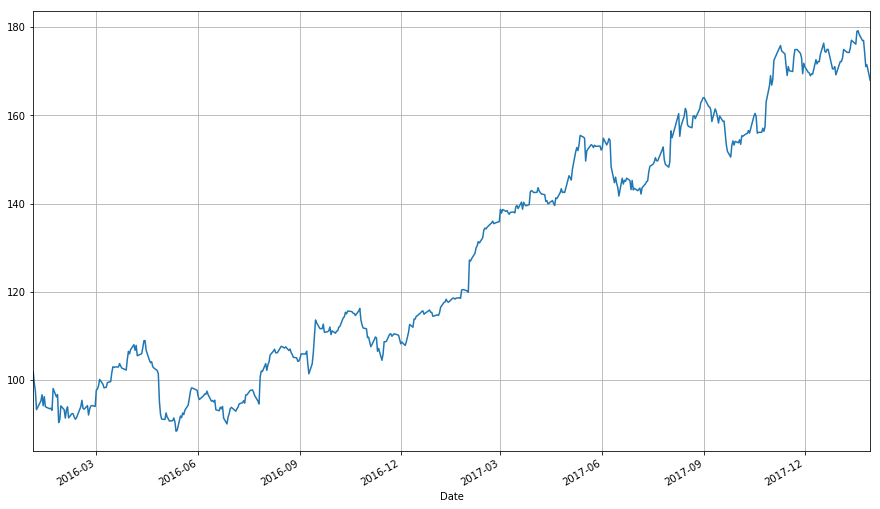

In [6]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots

apple["Adj. Close"].plot(grid = True) # Plot the adjusted closing price of AAPL

A linechart is fine, but there are at least four variables involved for each date (open, high, low, and close), and we would like to have some visual way to see all four variables that does not require plotting four separate lines. Financial data is often plotted with a **Japanese candlestick plot**, so named because it was first created by 18th century Japanese rice traders. Such a chart can be created with **matplotlib**, though it requires considerable effort.

I have made a function you are welcome to use to more easily create candlestick charts from **pandas** data frames, and use it to plot our stock data. (Code is based off [this example](http://matplotlib.org/examples/pylab_examples/finance_demo.html), and you can read the documentation for the functions involved [here](http://matplotlib.org/api/finance_api.html).)

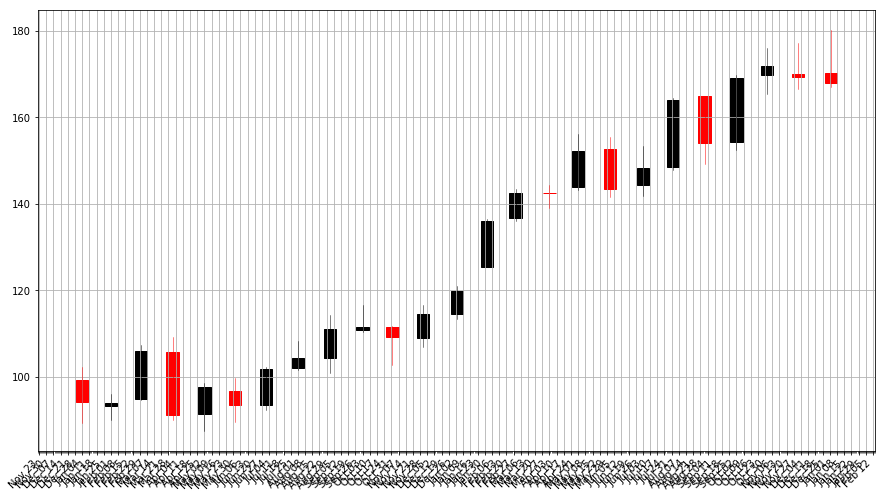

In [8]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
    
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
    
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
                               
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
            
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
    
    ax.grid(True)
    
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
    
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

pandas_candlestick_ohlc(apple, adj=True, stick="month")

With a candlestick chart, a black candlestick indicates a day where the closing price was higher than the open (a gain), while a red candlestick indicates a day where the open was higher than the close (a loss). The wicks indicate the high and the low, and the body the open and close (hue is used to determine which end of the body is the open and which the close). Candlestick charts are popular in finance and some strategies in [technical analysis](https://en.wikipedia.org/wiki/Technical_analysis) use them to make trading decisions, depending on the shape, color, and position of the candles. I will not cover such strategies today.

We may wish to plot multiple financial instruments together; we may want to compare stocks, compare them to the market, or look at other securities such as [exchange-traded funds (ETFs)](https://en.wikipedia.org/wiki/Exchange-traded_fund). Later, we will also want to see how to plot a financial instrument against some indicator, like a moving average. For this you would rather use a line chart than a candlestick chart. (How would you plot multiple candlestick charts on top of one another without cluttering the chart?)

Below, I get stock data for some other tech companies and plot their adjusted close together.

In [9]:
microsoft, google = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["MSFT", "GOOG"])

# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({"AAPL": apple["Adj. Close"],
                      "MSFT": microsoft["Adj. Close"],
                      "GOOG": google["Adj. Close"]})

stocks.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,101.783763,741.84,52.181598
2016-01-05,99.233131,742.58,52.419653
2016-01-06,97.291172,743.62,51.467434
2016-01-07,93.185040,726.39,49.677262
2016-01-08,93.677776,714.47,49.829617


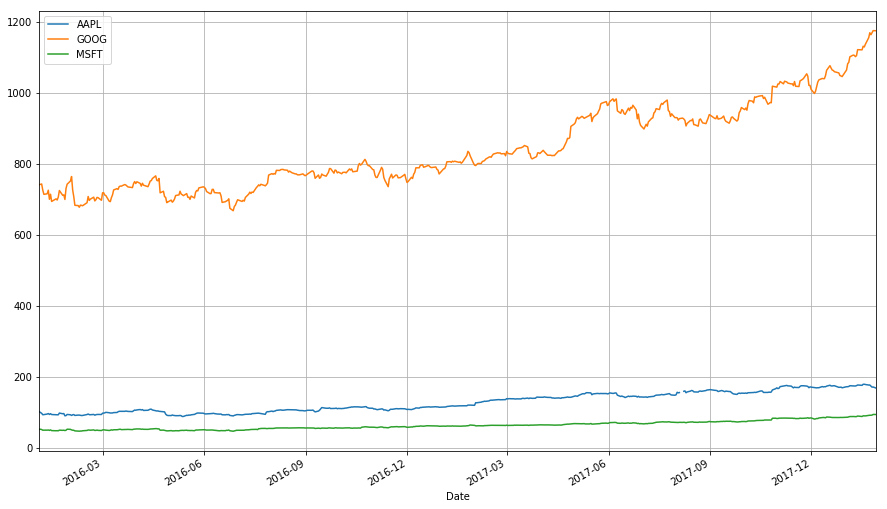

In [10]:
stocks.plot(grid = True)

What's wrong with this chart? While absolute price is important (pricy stocks are difficult to purchase, which affects not only their volatility but *your* ability to trade that stock), when trading, we are more concerned about the relative change of an asset rather than its absolute price. Google's stocks are much more expensive than Apple's or Microsoft's, and this difference makes Apple's and Microsoft's stocks appear much less volatile than they truly are (that is, their price appears to not deviate much).

One solution would be to use two different scales when plotting the data; one scale will be used by Apple and Microsoft stocks, and the other by Google.

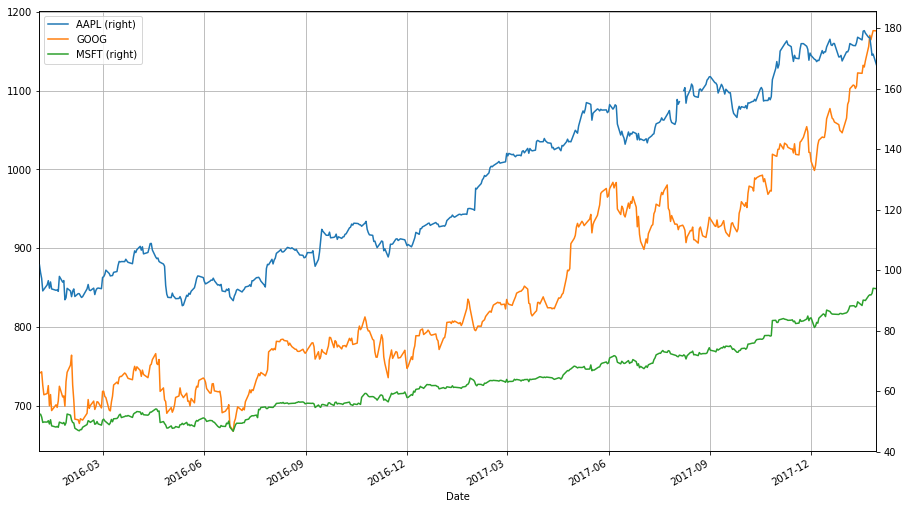

In [11]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)

A "better" solution, though, would be to plot the information we actually want: the stock's returns. This involves transforming the data into something more useful for our purposes. There are multiple transformations we could apply.

One transformation would be to consider the stock's return since the beginning of the period of interest. In other words, we plot:

\begin{equation*}
\text{return}_{t,0} = \frac{\text{price}_t}{\text{price}_0}
\end{equation*}

This will require transforming the data in the `stocks` object, which I do next. Notice that I am using a **lambda function**, which allows me to pass a small function defined quickly as a parameter to another function or method (you can read more about lambda functions [here](https://docs.python.org/3/reference/expressions.html#lambda)).

In [12]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,1.000000,1.000000,1.000000
2016-01-05,0.974941,1.000998,1.004562
2016-01-06,0.955861,1.002399,0.986314
2016-01-07,0.915520,0.979173,0.952007
2016-01-08,0.920361,0.963105,0.954927


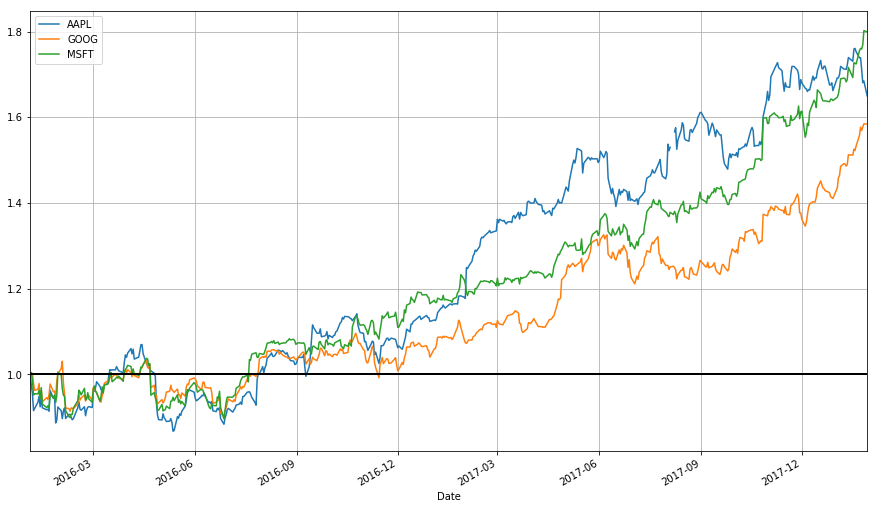

In [13]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

This is a much more useful plot. We can now see how profitable each stock was since the beginning of the period. Furthermore, we see that these stocks are highly correlated; they generally move in the same direction, a fact that was difficult to see in the other charts.

Alternatively, we could plot the change of each stock per day. One way to do so would be to plot the percentage increase of a stock when comparing day $t$ to day $t + 1$, with the formula:

\begin{equation*}
\text{growth}_t = \frac{\text{price}_{t + 1} - \text{price}_t}{\text{price}_t}
\end{equation*}

But change could be thought of differently as:

\begin{equation*}
\text{increase}_t = \frac{\text{price}_{t} - \text{price}_{t-1}}{\text{price}_t}
\end{equation*}

These formulas are not the same and can lead to differing conclusions, but there is another way to model the growth of a stock: with log differences.

\begin{equation*}
\text{change}_t = \log(\text{price}_{t}) - \log(\text{price}_{t - 1})
\end{equation*}

(Here, $\log$ is the natural log, and our definition does not depend as strongly on whether we use $\log(\text{price}_{t}) - \log(\text{price}_{t - 1})$ or $\log(\text{price}_{t+1}) - \log(\text{price}_{t})$.) The advantage of using log differences is that this difference can be interpreted as the percentage change in a stock but does not depend on the denominator of a fraction. Additionally, log differences have a desirable property: the sum of the log differences can be interpreted as the total change (as a percentage) over the period summed (which is not a property of the other formulations; they will overestimate growth). Log differences also more cleanly correspond to how stock prices are modeled in continuous time.

We can obtain and plot the log differences of the data in `stocks` as follows:

In [14]:
# Let's use NumPy's log function, though math's log function would work just as well
import numpy as np

stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,AAPL,GOOG,MSFT
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025379,0.000997,0.004552
2016-01-06,-0.019764,0.001400,-0.018332
2016-01-07,-0.043121,-0.023443,-0.035402
2016-01-08,0.005274,-0.016546,0.003062


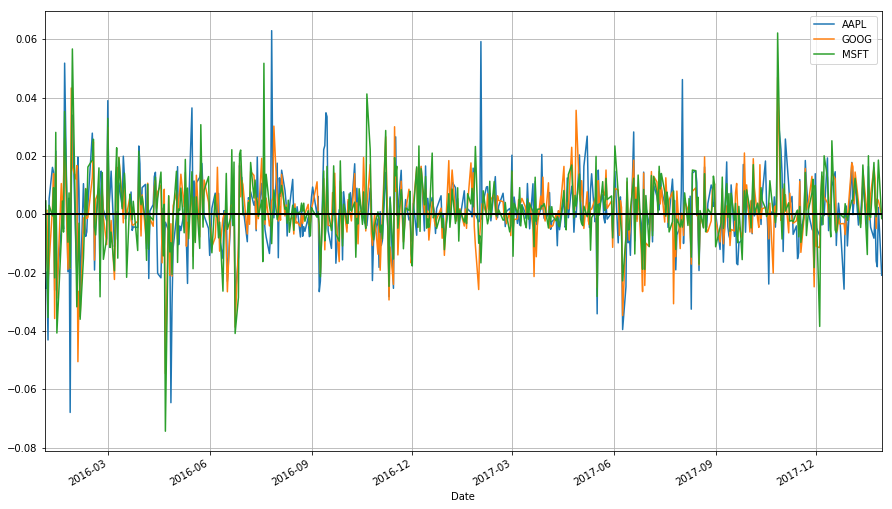

In [15]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

Which transformation do you prefer? Looking at returns since the beginning of the period make the overall trend of the securities in question much more apparent. Changes between days, though, are what more advanced methods actually consider when modelling the behavior of a stock. so they should not be ignored.

We often want to compare the performance of stocks to the performance of the overall market. [SPY](https://finance.yahoo.com/quote/SPY/), which is the ticker symbol for the SPDR S&P 500 exchange-traded mutual fund (ETF), is a fund that attempts only to imitate the composition of the [S&P 500 stock index](https://finance.yahoo.com/quote/%5EGSPC?p=^GSPC), and thus represents the value in "the market."

SPY data is not available for free from Quandl, so I will get this data from Yahoo! Finance. (I don't have a choice.)

Below I get data for SPY and compare its performance to the performance of our stocks.

In [16]:
#import pandas_datareader.data as web    # Going to get SPY from Yahoo! (I know I said you shouldn't but I didn't have a choice)
#spyder = web.DataReader("SPY", "yahoo", start, end)    # Didn't work
#spyder = web.DataReader("SPY", "google", start, end)    # Didn't work either
# If all else fails, read from a file, obtained from here: http://www.nasdaq.com/symbol/spy/historical
spyderdat = pd.read_csv("HistoricalQuotes.csv")    # Obviously specific to my system; set to
                                                                          # location on your machine
spyderdat = pd.DataFrame(spyderdat.loc[:, ["open", "high", "low", "close", "close"]].iloc[1:].as_matrix(),
                         index=pd.DatetimeIndex(spyderdat.iloc[1:, 0]),
                         columns=["Open", "High", "Low", "Close", "Adj Close"]).sort_index()

spyder = spyderdat.loc[start:end]

stocks = stocks.join(spyder.loc[:, "Adj Close"]).rename(columns={"Adj Close": "SPY"})
stocks.head()

,AAPL,GOOG,MSFT,SPY
Date,,,,
2016-01-04,101.783763,741.84,52.181598,201.0192
2016-01-05,99.233131,742.58,52.419653,201.3600
2016-01-06,97.291172,743.62,51.467434,198.8200
2016-01-07,93.185040,726.39,49.677262,194.0500
2016-01-08,93.677776,714.47,49.829617,191.9230


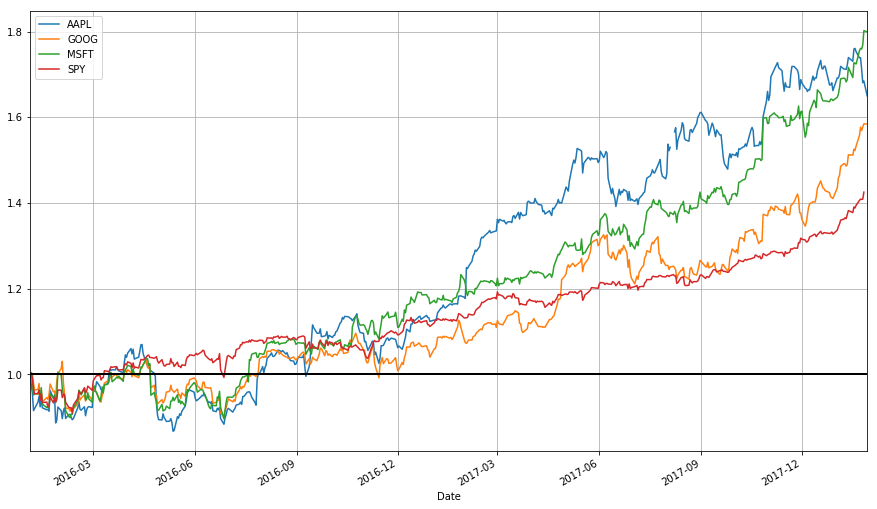

In [17]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

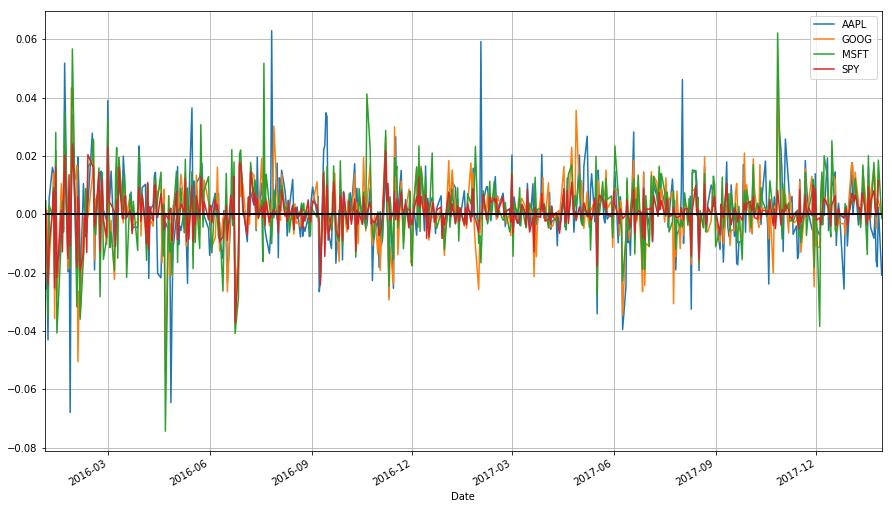

In [18]:
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
stock_change.plot(grid=True).axhline(y = 0, color = "black", lw = 2)

## Classical Risk Metrics

From what we have so far we can already compute informative metrics for our stocks, which can be considered some measure of risk.

First, we will want to **annualize** our returns, thus computing the **annual percentage rate (APR)**. This helps us keep returns on a common time scale.

In [19]:
stock_change_apr = stock_change * 252 * 100    # There are 252 trading days in a year; the 100 converts to percentages
stock_change_apr.tail()

,AAPL,GOOG,MSFT,SPY
Date,,,,
2018-01-23,5.694272,306.853106,79.646952,53.429470
2018-01-24,-404.632049,-123.721765,-21.946442,-9.786926
2018-01-25,-453.908545,132.335898,139.582219,10.676458
2018-01-26,58.840725,117.503761,467.806770,290.085326
2018-01-29,-527.076097,-5.572803,-37.535915,NaN


Some of these numbers look initially like nonsense, but that's okay for now.

The metrics I want are:
* The average return
* Volatility (the standard deviation of returns)
* $\alpha$ and $\beta$
* The Sharpe ratio

The first two metrics are largely self-explanatory, but the latter two need explaining.

First, the **risk-free rate**, which I denote by $r_{RF}$, is the rate of return on a risk-free financial asset. This asset exists only in theory but often yields on low-risk instruments like 3-month U.S. Treasury Bills can be viewed as being virtually risk-free and thus their yields can be used to approximate the risk-free rate. I get the data for these instruments below.

In [20]:
tbill = quandl.get("FRED/TB3MS", start_date=start, end_date=end)
tbill.tail()

,Value
Date,
2017-08-01,1.01
2017-09-01,1.03
2017-10-01,1.07
2017-11-01,1.23
2017-12-01,1.32


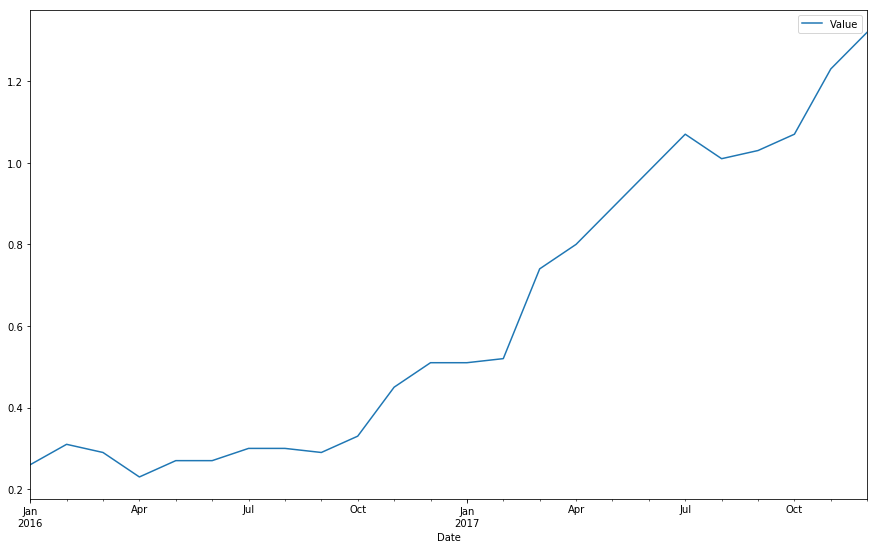

In [21]:
tbill.plot()

In [22]:
rrf = tbill.iloc[-1, 0]    # Get the most recent Treasury Bill rate
rrf

1.3200000000000001

Now, a **linear regression model** is a model of the following form:

$$y_i = \alpha + \beta x_i + \epsilon_i$$

$\epsilon_i$ is an error process. Another way to think of this process model is:

$$\hat{y}_i = \alpha + \beta x_i$$

$\hat{y}_i$ is the **predicted value** of $y_i$ given $x_i$. In other words, a linear regression model tells you how $x_i$ and $y_i$ are related, and how values of $x_i$ can be used to predict values of $y_i$. $\alpha$ is the **intercept** of the model and $\beta$ is the **slope**. In particular, $\alpha$ would be the predicted value of $y$ if $x$ were zero, and $\beta$ gives how much $y$ changes when $x$ changes by one unit.

There is an easy way to compute $\alpha$ and $\beta$ given the sample means $\bar{x}$ and $\bar{y}$ and sample standard deviations $s_x$ and $s_y$ and the correlation between $x$ and $y$, denoted with $r$:

$$\beta = r \frac{s_y}{s_x}$$
$$\alpha = \bar{y} - \beta \bar{x}$$

In finance, we use $\alpha$ and $\beta$ like so:

$$R_t - r_{RF} = \alpha + \beta (R_{Mt} - r_{RF}) + \epsilon_t$$

$R_t$ is the return of a financial asset (a stock) and $R_t - r_{RF}$ is the **excess return**, or return exceeding the risk-free rate of return. $R_{Mt}$ is the return of the *market* at time $t$. Then $\alpha$ and $\beta can be interpreted like so:

* $\alpha$ is average excess return over the market.
* $\beta$ is how much a stock moves in relation to the market. If $\beta > 0$ then the stock generally moves in the same direction as the market, while when $\beta < 0$ the stock generally moves in the opposite direction. If $|\beta| > 1$ the stock moves strongly in response to the market $|\beta| < 1$ the stock is less responsive to the market.

Below I get a **pandas** `Series` that contains how much each stock is correlated with SPY (our approximation of the market).

In [23]:
smcorr = stock_change_apr.drop("SPY", 1).corrwith(stock_change_apr.SPY)    # Since RRF is constant it doesn't change the
                                                                           # correlation so we can ignore it in our
                                                                           # calculation
smcorr

AAPL    0.545693
GOOG    0.593251
MSFT    0.671729
dtype: float64

Then I compute $\alpha$ and $\beta$.

In [24]:
sy = stock_change_apr.drop("SPY", 1).std()
sx = stock_change_apr.SPY.std()
sy

AAPL    326.744776
GOOG    281.493814
MSFT    301.879258
dtype: float64

In [25]:
sx

164.56366925855286

In [26]:
ybar = stock_change_apr.drop("SPY", 1).mean() - rrf
xbar = stock_change_apr.SPY.mean() - rrf
ybar

AAPL    21.912379
GOOG    20.990885
MSFT    27.161498
dtype: float64

In [27]:
xbar

15.898412419581888

In [28]:
beta = smcorr * sy / sx
alpha = ybar - beta * xbar
beta

AAPL    1.083486
GOOG    1.014783
MSFT    1.232234
dtype: float64

In [29]:
alpha

AAPL    4.686678
GOOG    4.857448
MSFT    7.570934
dtype: float64

The **Sharpe ratio** is another popular risk metric, defined below:

$$\text{Sharpe ratio} = \frac{\bar{R_t} - r_{RF}}{s}$$

Here $s$ is the volatility of the stock. We want the sharpe ratio to be large. A large Sharpe ratio indicates that the stock's excess returns are large relative to the stock's volatilitly. Additionally, the Sharpe ratio is tied to a statistical test (the $t$-test) to determine if a stock earns more on average than the risk-free rate; the larger this ratio, the more likely this is to be the case.

Your challenge now is to compute the Sharpe ratio for each stock listed here, and interpret it. Which stock seems to be the better investment according to the Sharpe ratio?

In [30]:
sharpe = (ybar - rrf)/sy
sharpe

AAPL    0.063023
GOOG    0.069880
MSFT    0.085602
dtype: float64

## Moving Averages

Charts are very useful. In fact, some traders base their strategies almost entirely off charts (these are the "technicians", since trading strategies based off finding patterns in charts is a part of the trading doctrine known as **technical analysis**). Let's now consider how we can find trends in stocks.

A **$q$-day moving average** is, for a series $x_t$ and a point in time $t$, the average of the past $q$ days: that is, if $MA^q_t$ denotes a moving average process, then:

\begin{equation*}
MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}
\end{equation*}

Moving averages smooth a series and helps identify trends. The larger $q$ is, the less responsive a moving average process is to short-term fluctuations in the series $x_t$. The idea is that moving average processes help identify trends from "noise". **Fast** moving averages have smaller $q$ and more closely follow the stock, while **slow** moving averages have larger $q$, resulting in them responding less to the fluctuations of the stock and being more stable.

**pandas** provides functionality for easily computing moving averages. I demonstrate its use by creating a 20-day (one month) moving average for the Apple data, and plotting it alongside the stock.

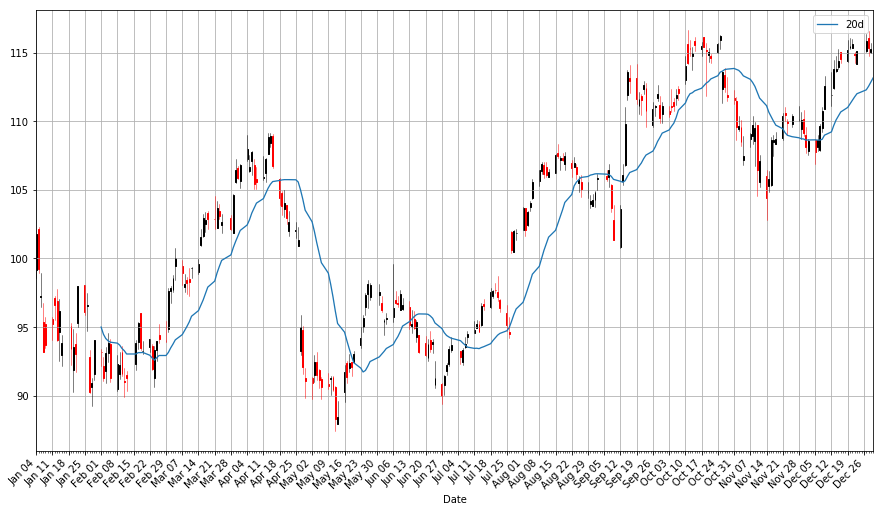

In [31]:
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = "20d", adj=True)

Notice how late the rolling average begins. It cannot be computed until 20 days have passed. This limitation becomes more severe for longer moving averages. Because I would like to be able to compute 200-day moving averages, I'm going to extend out how much AAPL data we have. That said, we will still largely focus on 2016.

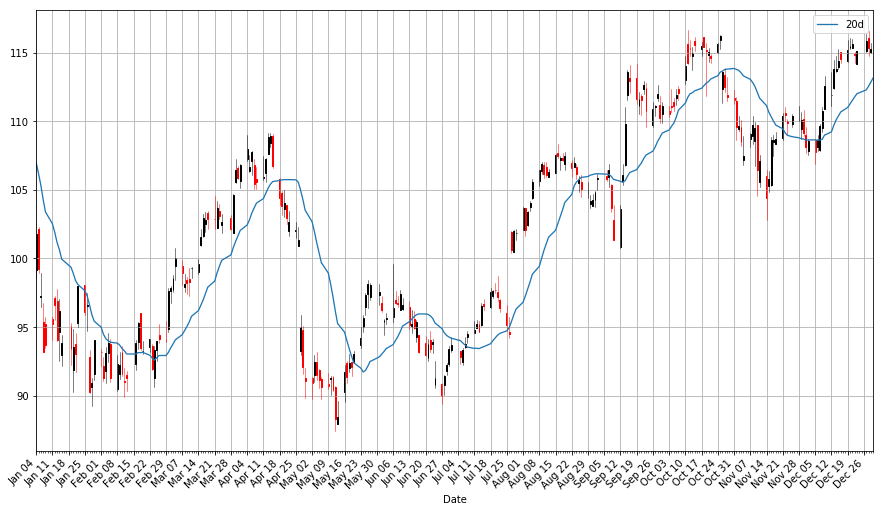

In [32]:
start = datetime.datetime(2010,1,1)
apple = quandl.get("WIKI/AAPL", start_date=start, end_date=end)
apple["20d"] = np.round(apple["Adj. Close"].rolling(window = 20, center = False).mean(), 2)

pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = "20d", adj=True)

You will notice that a moving average is much smoother than the actua stock data. Additionally, it's a stubborn indicator; a stock needs to be above or below the moving average line in order for the line to change direction. Thus, crossing a moving average signals a possible change in trend, and should draw attention.

Traders are usually interested in multiple moving averages, such as the 20-day, 50-day, and 200-day moving averages. It's easy to examine multiple moving averages at once.

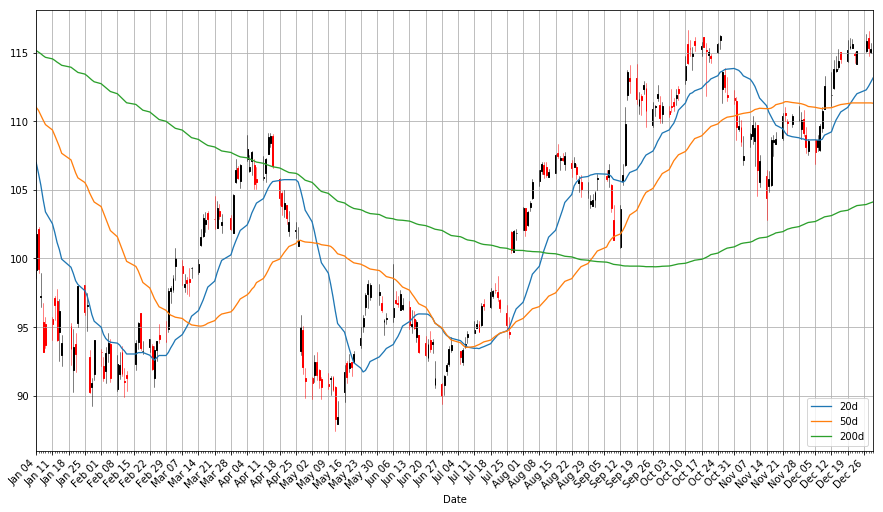

In [33]:
apple["50d"] = np.round(apple["Adj. Close"].rolling(window = 50, center = False).mean(), 2)
apple["200d"] = np.round(apple["Adj. Close"].rolling(window = 200, center = False).mean(), 2)

pandas_candlestick_ohlc(apple.loc['2016-01-04':'2016-12-31',:], otherseries = ["20d", "50d", "200d"], adj=True)

The 20-day moving average is the most sensitive to local changes, and the 200-day moving average the least. Here, the 200-day moving average indicates an overall **bearish** trend: the stock is trending downward over time. The 20-day moving average is at times bearish and at other times **bullish**, where a positive swing is expected. You can also see that the crossing of moving average lines indicate changes in trend. These crossings are what we can use as **trading signals**, or indications that a financial security is changind direction and a profitable trade might be made.

## Trading Strategy

Our concern now is to design and evaluate trading strategies.

Any trader must have a set of rules that determine how much of her money she is willing to bet on any single trade. For example, a trader may decide that under no circumstances will she risk more than 10% of her portfolio on a trade. Additionally, in any trade, a trader must have an **exit strategy**, a set of conditions determining when she will exit the position, for either profit or loss. A trader may set a **target**, which is the minimum profit that will induce the trader to leave the position. Likewise, a trader may have a maximum loss she is willing to tolerate; if potential losses go beyond this amount, the trader will exit the position in order to prevent any further loss. We will suppose that the amount of money in the portfolio involved in any particular trade is a fixed proportion; 10% seems like a good number.

Here, I will be demonstrating a [moving average crossover strategy](http://www.investopedia.com/university/movingaverage/movingaverages4.asp). We will use two moving averages, one we consider "fast", and the other "slow". The strategy is:

* Trade the asset when the fast moving average crosses over the slow moving average.
* Exit the trade when the fast moving average crosses over the slow moving average again.

A trade will be prompted when the fast moving average crosses from below to above the slow moving average, and the trade will be exited when the fast moving average crosses below the slow moving average later.

We now have a complete strategy. But before we decide we want to use it, we should try to evaluate the quality of the strategy first. The usual means for doing so is **backtesting**, which is looking at how profitable the strategy is on historical data. For example, looking at the above chart's performance on Apple stock, if the 20-day moving average is the fast moving average and the 50-day moving average the slow, this strategy does not appear to be very profitable, at least not if you are always taking long positions.

Let's see if we can automate the backtesting task. We first identify when the 20-day average is below the 50-day average, and vice versa.

In [ ]:
apple['20d-50d'] = apple['20d'] - apple['50d']
apple.tail()

We will refer to the sign of this difference as the **regime**; that is, if the fast moving average is above the slow moving average, this is a bullish regime (the bulls rule), and a bearish regime (the bears rule) holds when the fast moving average is below the slow moving average. I identify regimes with the following code.

In [ ]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
apple["Regime"] = np.where(apple['20d-50d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
apple["Regime"] = np.where(apple['20d-50d'] < 0, -1, apple["Regime"])
apple.loc['2016-01-04':'2016-12-31',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [ ]:
apple["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [ ]:
apple["Regime"].value_counts()

The last line above indicates that for 1005 days the market was bearish on Apple, while for 600 days the market was bullish, and it was neutral for 54 days.

Trading signals appear at regime changes. When a bullish regime begins, a buy signal is triggered, and when it ends, a sell signal is triggered. Likewise, when a bearish regime begins, a sell signal is triggered, and when the regime ends, a buy signal is triggered (this is of interest only if you ever will short the stock, or use some derivative like a stock option to bet against the market).

It's simple to obtain signals. Let $r_t$ indicate the regime at time $t$, and $s_t$ the signal at time $t$. Then:

\begin{equation*}
s_t = \text{sign}(r_t - r_{t - 1})
\end{equation*}

$s_t \in \{-1, 0, 1\}$, with $-1$ indicating "sell", $1$ indicating "buy", and $0$ no action. We can obtain signals like so:

In [ ]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = apple.loc[:, "Regime"].iloc[-1]
apple.loc[:, "Regime"].iloc[-1] = 0
apple["Signal"] = np.sign(apple["Regime"] - apple["Regime"].shift(1))
# Restore original regime data
apple.loc[:, "Regime"].iloc[-1] = regime_orig
apple.tail()

In [ ]:
apple["Signal"].plot(ylim = (-2, 2))

In [ ]:
apple["Signal"].value_counts()

We would buy Apple stock 23 times and sell Apple stock 23 times. If we only go long on Apple stock, only 23 trades will be engaged in over the 6-year period, while if we pivot from a long to a short position every time a long position is terminated, we would engage in 23 trades total. (Bear in mind that trading more frequently isn't necessarily good; trades are never free.)

You may notice that the system as it currently stands isn't very robust, since even a fleeting moment when the fast moving average is above the slow moving average triggers a trade, resulting in trades that end immediately (which is bad if not simply because realistically every trade is accompanied by a fee that can quickly erode earnings). Additionally, every bullish regime immediately transitions into a bearish regime, and if you were constructing trading systems that allow both bullish and bearish bets, this would lead to the end of one trade immediately triggering a new trade that bets on the market in the opposite direction, which again seems finnicky. A better system would require more evidence that the market is moving in some particular direction. But we will not concern ourselves with these details for now.

Let's now try to identify what the prices of the stock is at every buy and every sell.

In [ ]:
apple.loc[apple["Signal"] == 1, "Close"]

In [ ]:
apple.loc[apple["Signal"] == -1, "Close"]

In [ ]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
apple_signals = pd.concat([
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == 1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": apple.loc[apple["Signal"] == -1, "Adj. Close"],
                     "Regime": apple.loc[apple["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
apple_signals.sort_index(inplace = True)
apple_signals

In [ ]:
# Let's see the profitability of long trades
apple_long_profits = pd.DataFrame({
        "Price": apple_signals.loc[(apple_signals["Signal"] == "Buy") &
                                  apple_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(apple_signals["Price"] - apple_signals["Price"].shift(1)).loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": apple_signals["Price"].loc[
            apple_signals.loc[(apple_signals["Signal"].shift(1) == "Buy") & (apple_signals["Regime"].shift(1) == 1)].index
        ].index
    })
apple_long_profits

Let's now create a simulated portfolio of $1,000,000, and see how it would behave, according to the rules we have established. This includes:

* Investing only 10% of the portfolio in any trade
* Exiting the position if losses exceed 20% of the value of the trade.

When simulating, bear in mind that:

* Trades are done in batches of 100 stocks.
* Our stop-loss rule involves placing an order to sell the stock the moment the price drops below the specified level. Thus we need to check whether the lows during this period ever go low enough to trigger the stop-loss. Realistically, unless we buy a put option, we cannot guarantee that we will sell the stock at the price we set at the stop-loss, but we will use this as the selling price anyway for the sake of simplicity.
* Every trade is accompanied by a commission to the broker, which should be accounted for. I do not do so here.

Here's how a backtest may look:

In [ ]:
# We need to get the low of the price during each trade.
tradeperiods = pd.DataFrame({"Start": apple_long_profits.index,
                            "End": apple_long_profits["End Date"]})
apple_long_profits["Low"] = tradeperiods.apply(lambda x: min(apple.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
apple_long_profits

In [ ]:
# Now we have all the information needed to simulate this strategy in apple_adj_long_profits
cash = 1000000
apple_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = .1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch
stoploss = .2    # % of trade loss that would trigger a stoploss
for index, row in apple_long_profits.iterrows():
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    apple_backtest = apple_backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)

apple_backtest

In [ ]:
apple_backtest["End Port. Value"].plot()

Our portfolio's value grew by 13% in about six years. Considering that only 10% of the portfolio was ever involved in any single trade, this is not bad performance.

Notice that this strategy never lead to our rule of never allowing losses to exceed 20% of the trade's value being invoked. For the sake of simplicity, we will ignore this rule in backtesting.

A more realistic portfolio would not be betting 10% of its value on only one stock. A more realistic one would consider investing in multiple stocks. Multiple trades may be ongoing at any given time involving multiple companies, and most of the portfolio will be in stocks, not cash. Now that we will be investing in multiple stops and exiting only when moving averages cross (not because of a stop-loss), we will need to change our approach to backtesting. For example, we will be using one **pandas** `DataFrame` to contain all buy and sell orders for all stocks being considered, and our loop above will have to track more information.

I have written functions for creating order data for multiple stocks, and a function for performing the backtesting.

In [ ]:
def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average
    
    :return: pandas DataFrame containing stock orders
    
    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str
    
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = np.round(s[1]["Close"].rolling(window = fast, center = False).mean(), 2)
        s[1][slow_str] = np.round(s[1]["Close"].rolling(window = slow, center = False).mean(), 2)
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]
        
        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].loc[:, "Regime"].iloc[-1]
        s[1].loc[:, "Regime"].iloc[-1] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].loc[:, "Regime"].iloc[-1] = regime_orig
        
        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Adj. Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
    
    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
    
    return trades


def backtest(signals, cash, port_value = .1, batch = 100):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes
    
    :return: pandas DataFrame with backtesting results
    
    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """
    
    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})
    
    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared
        
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
            
        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])
        
        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero
            
        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance
    
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
    
    return results

# Get more stocks
(microsoft, google, facebook, twitter, netflix,
amazon, yahoo, ge, qualcomm, ibm, hp) = (quandl.get("WIKI/" + s, start_date=start,
                                                                         end_date=end) for s in ["MSFT", "GOOG", "FB", "TWTR",
                                                                                                 "NFLX", "AMZN", "YHOO", "GE",
                                                                                                 "QCOM", "IBM", "HPQ"])

In [ ]:
signals = ma_crossover_orders([("AAPL", apple),
                              ("MSFT",  microsoft),
                              ("GOOG",  google),
                              ("FB",    facebook),
                              ("TWTR",  twitter),
                              ("NFLX",  netflix),
                              ("AMZN",  amazon),
                              ("YHOO",  yahoo),
                              ("GE",    ge),
                              ("QCOM",  qualcomm),
                              ("IBM",   ibm),
                              ("HPQ",   hp)],
                            fast = 20, slow = 50)
signals

In [ ]:
bk = backtest(signals, 1000000)
bk

In [ ]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()

A more realistic portfolio that can invest in any in a list of twelve (tech) stocks has a final growth of about 100%. How good is this? While on the surface not bad, we will see we could have done better.

## Benchmarking

Backtesting is only part of evaluating the efficacy of a trading strategy. We would like to **benchmark** the strategy, or compare it to other available (usually well-known) strategies in order to determine how well we have done.

Whenever you evaluate a trading system, there is one strategy that you should always check, one that beats all but a handful of managed mutual funds and investment managers: buy and hold [SPY](https://finance.yahoo.com/quote/SPY). The **efficient market hypothesis** claims that it is all but impossible for anyone to beat the market. Thus, one should always buy an index fund that merely reflects the composition of the market.By buying and holding SPY, we are effectively trying to match our returns with the market rather than beat it.

I look at the profits for simply buying and holding SPY.

In [ ]:
#spyder = web.DataReader("SPY", "yahoo", start, end)
spyder = spyderdat.loc[start:end]
spyder.iloc[[0,-1],:]

In [ ]:
batches = 1000000 // np.ceil(100 * spyder.loc[:,"Adj Close"].iloc[0]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * spyder.loc[:,"Adj Close"].iloc[0] # How much money is used to buy SPY
final_val = batches * batch * spyder.loc[:,"Adj Close"].iloc[-1] + (1000000 - trade_val) # Final value of the portfolio
final_val

In [ ]:
# We see that the buy-and-hold strategy beats the strategy we developed earlier. I would also like to see a plot.
ax_bench = (spyder["Adj Close"] / spyder.loc[:, "Adj Close"].iloc[0]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 1000000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench

Buying and holding SPY beats our trading system, at least how we currently set it up, and we haven't even accounted for how expensive our more complex strategy is in terms of fees. Given both the opportunity cost and the expense associated with the active strategy, we should not use it.

What could we do to improve the performance of our system? For starters, we could try diversifying. All the stocks we considered were tech companies, which means that if the tech industry is doing poorly, our portfolio will reflect that. We could try developing a system that can also short stocks or bet bearishly, so we can take advantage of movement in any direction. We could seek means for forecasting how high we expect a stock to move. Whatever we do, though, must beat this benchmark; otherwise there is an opportunity cost associated with our trading system.

Other benchmark strategies exist, and if our trading system beat the "buy and hold SPY" strategy, we may check against them. Some such strategies include:

* Buy SPY when its closing monthly price is aboves its ten-month moving average.
* Buy SPY when its ten-month momentum is positive. (**Momentum** is the first difference of a moving average process, or $MO^q_t = MA^q_t - MA^q_{t - 1}$.)

(I first read of these strategies [here](https://www.r-bloggers.com/are-r2s-useful-in-finance-hypothesis-driven-development-in-reverse/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A+RBloggers+%28R+bloggers%29).) The general lesson still holds: *don't use a complex trading system with lots of active trading when a simple strategy involving an index fund without frequent trading beats it.* [This is actually a very difficult requirement to meet.](http://www.nytimes.com/2015/03/15/your-money/how-many-mutual-funds-routinely-rout-the-market-zero.html?_r=0)

As a final note, suppose that your trading system *did* manage to beat any baseline strategy thrown at it in backtesting. Does backtesting predict future performance? Not at all. [Backtesting has a propensity for overfitting](http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2745220), so just because backtesting predicts high growth doesn't mean that growth will hold in the future. There are strategies for combatting overfitting, such as [walk-forward analysis](https://ntguardian.wordpress.com/2017/06/19/walk-forward-analysis-demonstration-backtrader/) and holding out a portion of a dataset (likely the most recent part) as a final test set to determine if a strategy is profitable, followed by "sitting on" a strategy that managed to survive these two filters and seeing if it remains profitable in current markets.

## Conclusion

While this lecture ends on a depressing note, keep in mind that [the efficient market hypothesis has many critics.](http://www.nytimes.com/2009/06/06/business/06nocera.html) My own opinion is that as trading becomes more algorithmic, beating the market will become more difficult. That said, it may be possible to beat the market, even though mutual funds seem incapable of doing so (bear in mind, though, that part of the reason mutual funds perform so poorly is because of fees, which is not a concern for index funds).

This lecture is very brief, covering only one type of strategy: strategies based on moving averages. Many other trading signals exist and employed. Additionally, we never discussed in depth shorting stocks, currency trading, or stock options. Stock options, in particular, are a rich subject that offer many different ways to bet on the direction of a stock. You can read more about derivatives (including stock options and other derivatives) in the book *Derivatives Analytics with Python: Data Analysis, Models, Simulation, Calibration and Hedging*, [which is available from the University of Utah library.](http://proquest.safaribooksonline.com.ezproxy.lib.utah.edu/9781119037996)

Another resource (which I used as a reference while writing this lecture) is the O'Reilly book *Python for Finance*, [also available from the University of Utah library.](http://proquest.safaribooksonline.com.ezproxy.lib.utah.edu/book/programming/python/9781491945360)

If you were interested in investigating algorithmic trading, where would you go from here? I would not recommend using the code I wrote above for backtesting; there are better packages for this task. Python has some libraries for algorithmic trading, such as [**pyfolio**](https://quantopian.github.io/pyfolio/) (for analytics), [**zipline**](http://www.zipline.io/beginner-tutorial.html) (for backtesting and algorithmic trading), and [**backtrader**](https://www.backtrader.com/) (also for backtesting and trading). **zipline** seems to be popular likely because it is used and developed by [**quantopian**](https://www.quantopian.com/), a "crowd-sourced hedge fund" that allows users to use their data for backtesting and even will license profitable strategies from their authors, giving them a cut of the profits. However, I prefer **backtrader** and have written [blog posts](https://ntguardian.wordpress.com/tag/backtrader/) on using it. It is likely the more complicated between the two but that's the cost of greater power. I am a fan of its design. I also would suggest learning [R](https://www.r-project.org/), since it has many packages for analyzing financial data (moreso than Python) and it's surprisingly easy to use R functions in Python (as I demonstrate in [this post](https://ntguardian.wordpress.com/2017/06/28/stock-trading-analytics-and-optimization-in-python-with-pyfolio-rs-performanceanalytics-and-backtrader/)).

You can read more about using R and Python for finance on [my blog](https://ntguardian.wordpress.com).

Remember that it is possible (if not common) to lose money in the stock market. It's also true, though, that it's difficult to find returns like those found in stocks, and any investment strategy should take investing in it seriously. This lecture is intended to provide a starting point for evaluating stock trading and investments, and, more generally, analyzing temporal data, and I hope you continue to explore these ideas.